In [1]:
# Imports
import torch
import matplotlib.pyplot as plt
import numpy as np

import path   # adds repo to PATH
from modules.model import Rotated_cINN
from modules.data import RotatedMNIST

In [2]:
# Parameters
save_path = path.package_directory + '/trained_models/rotated_cinn.pt'
device = 'cuda'  if torch.cuda.is_available() else  'cpu'
random_seed = 1
train_domains = [-23, 0, 23, 45, 90, 180]
test_domains = [-135, -90, -45, 10, 30, 60, 75, 135]
samples_per_domain = 100
ndim_total = 28 * 28

In [26]:
# Main functions
## Plotting losses
def show_domain_bar_plot(train_loss:dict[list], test_loss:dict[list]) -> None:

    fig, ax = plt.subplots(layout='constrained')

    # Spots for the bars on the x-axis
    test_spots = np.arange(len(test_loss['angles']))
    train_spots = np.nonzero(np.in1d(test_loss['angles'], train_loss['angles']))[0]
    width = 1/3  # the width of the bars
    
    # Train and test bars with error
    ax.bar(train_spots - width/2, train_loss['mean'], width=width, label='train')
    ax.errorbar(train_spots - width/2, train_loss['mean'], train_loss['err'], fmt=',', ecolor='black')
    ax.bar(test_spots + width/2, test_loss['mean'], width=width, label='test')
    ax.errorbar(test_spots + width/2, test_loss['mean'], test_loss['err'], fmt=',', ecolor='black')

    # Title, labels, etc.
    ax.set_title('MaxLikelihood loss of Rotated cINN')
    #ax.set_ylim(0, 1.1 * max(max(train_loss['angles']), max(test_loss['angles'])))
    ax.set_xticks(test_spots, labels=test_loss['angles'])
    ax.legend(loc='upper center', ncols=2)

    plt.show()

In [4]:
### Support functions for show_domain_bar_plot()
def compute_loss(model_output: torch.Tensor) -> tuple[float]:
    z, log_j = model_output
    losses = (z**2).mean(dim=1) / 2 - log_j / ndim_total
    std, mean = torch.std_mean(losses)
    mean_err = std / len(z)

    return (float(mean), float(mean_err))

In [18]:
def get_per_domain_loss(domains:list[int], dataset:RotatedMNIST, model:Rotated_cINN, number:int) -> dict[list]:
    loss_info = {'angles':domains, 'mean':[], 'err':[]}
    for domain in domains:
        domain_indices = torch.argwhere(domain == dataset.domain_labels)
        used_indices = domain_indices[:number].squeeze(1)
        
        data = dataset.data[used_indices]
        targets = dataset.targets[used_indices]
        output = model(data, targets)
        
        mean, err = compute_loss(output)
        loss_info['mean'].append(mean)
        loss_info['err'].append(err)

    return loss_info

In [6]:
## Showing generated images
def show_example_images():
    pass

In [19]:
# Main code
if __name__ == "__main__":
    torch.no_grad()
    
    # Load trained model
    cinn = Rotated_cINN().to(device)
    state_dict = {k:v for k,v in torch.load(save_path).items() if 'tmp_var' not in k}
    cinn.load_state_dict(state_dict)
    cinn.eval()

    # Load datasets
    all_domains = sorted(train_domains + test_domains)
    train_set = RotatedMNIST(domains=train_domains, train=True, seed=random_seed, val_set_size=1000)
    test_set = RotatedMNIST(domains=all_domains, train=False, seed=random_seed)


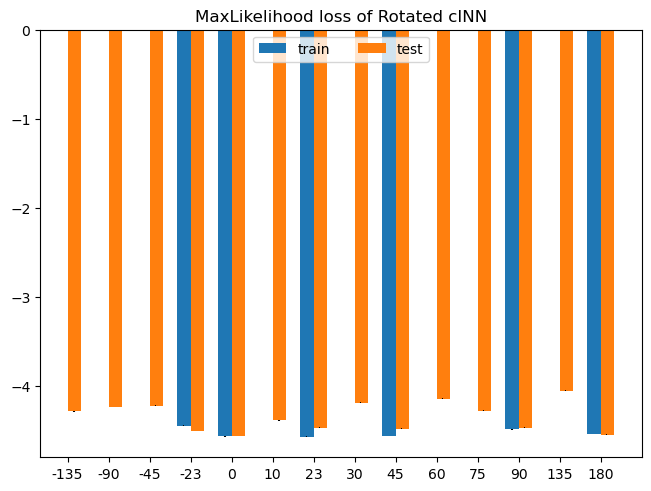

In [27]:
    # Calculate loss for each domain
    train_domain_loss = get_per_domain_loss(train_domains, train_set, cinn, samples_per_domain)
    test_domain_loss = get_per_domain_loss(all_domains, test_set, cinn, samples_per_domain)

    # Plot losses
    show_domain_bar_plot(train_domain_loss, test_domain_loss)

In [ ]:
all_domains

[-135, -90, -45, -23, 0, 10, 23, 30, 45, 60, 75, 90, 135, 180]

In [8]:
train_domain_loss

{'angles': [-23, 0, 23, 45, 90, 180],
 'mean': [-4.445914268493652,
  -4.565443992614746,
  -4.566565990447998,
  -4.558806419372559,
  -4.48470401763916,
  -4.53723669052124],
 'err': [0.0040816362015903,
  0.003116009524092078,
  0.0037074731662869453,
  0.00319852028042078,
  0.0030246952082961798,
  0.0035322392359375954]}

In [ ]:
domain = train_domains[0]
dataset = train_set
number = samples_per_domain
model = cinn


domain_indices = torch.argwhere(domain == dataset.domain_labels)
used_indices = domain_indices[:number].squeeze(1)
print(used_indices)
print(dataset.domain_labels[used_indices])

data = dataset.data[used_indices]
targets = dataset.targets[used_indices]
output = model(data, targets)
z, log_j = output
print(type(z), (z**2).mean(dim=1).shape)
print(type(log_j), log_j.shape)

mean, err = compute_loss(output)
print(mean, err)


tensor([  5,  11,  12,  16,  21,  33,  42,  46,  49,  55,  71,  77,  81,  91,
        101, 112, 115, 128, 132, 140, 142, 144, 148, 151, 153, 157, 162, 165,
        172, 175, 179, 181, 182, 185, 191, 195, 198, 203, 215, 220, 222, 237,
        241, 254, 259, 261, 272, 288, 290, 293, 294, 298, 299, 304, 308, 324,
        337, 339, 340, 342, 345, 348, 365, 370, 379, 383, 390, 393, 404, 407,
        411, 414, 427, 432, 435, 436, 455, 457, 463, 465, 470, 471, 472, 474,
        480, 492, 495, 504, 506, 510, 517, 521, 528, 532, 534, 537, 544, 561,
        568, 574])
tensor([-23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23,
        -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23,
        -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23,
        -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23,
        -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23,
        -23, -23, -23, -23, -23, -23, -23, -2